# Further Testing and Tinkering of Kappa

A new notebook was necessary in order to maintain previous results.

We have now implemented a sigma-dependent threshold on gamma and have added an Exception error that impedes gamma from becoming negative.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

In [ ]:
runs = {}

In [8]:
kappas = [0,0.5,1]

for k in kappas:    
    print(f"currently on kappa %s " %k)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= 4 * np.ones(751),
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            kappa=k, 
            sigma = 0.01,
            outtime=np.arange(1750.5,2501),
            dt=1
        )
        
        out = scm.run()
    
    runs[f"Constant 4xCO2 forcing, kappa: %s" %k] = out

currently on kappa 0 


100%|██████████| 1000/1000 [01:00<00:00, 16.55it/s]


currently on kappa 0.5 


100%|██████████| 1000/1000 [00:59<00:00, 16.72it/s]


currently on kappa 1 


100%|██████████| 1000/1000 [01:01<00:00, 16.27it/s]


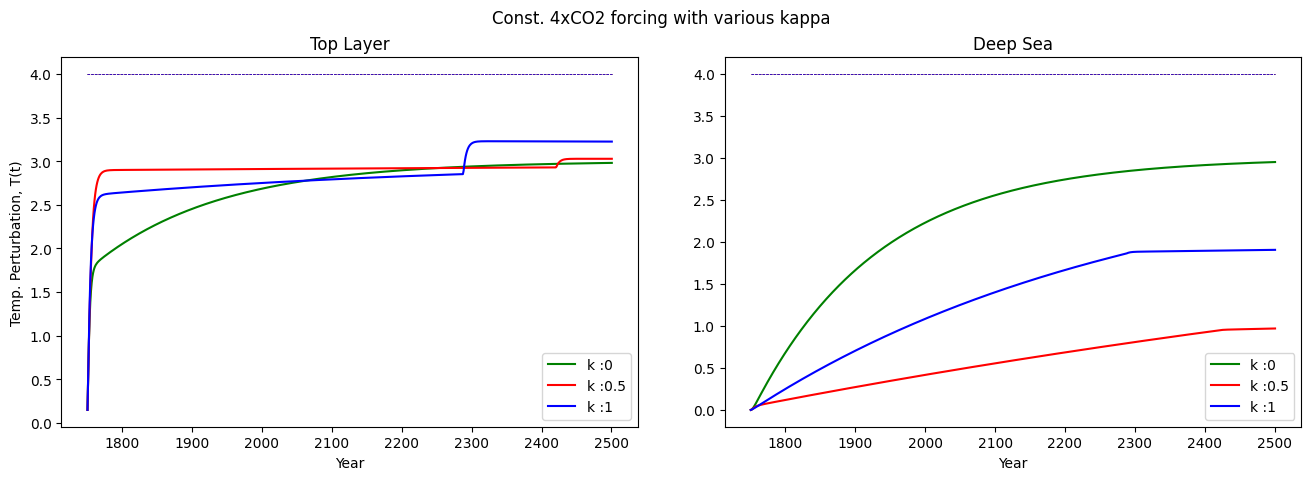

In [9]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)')

fig.suptitle("Const. 4xCO2 forcing with various kappa")
#print(runs)

scenario_names = []
for k in kappas:
    scenario_names.append(f"Constant 4xCO2 forcing, kappa: %s" %k)
#print(scenario_names)

run_outputs = [runs.get(key) for key in scenario_names]
#print(run_outputs)

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b", "m", "c"]

for (run, scen, color, k) in zip (run_outputs, scenario_names, colors, kappas):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = f"k :%s"%k, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = f"k :%s"%k, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, 4* np.ones(751), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
    
    
for subpl in axs:
     
    subpl.legend()

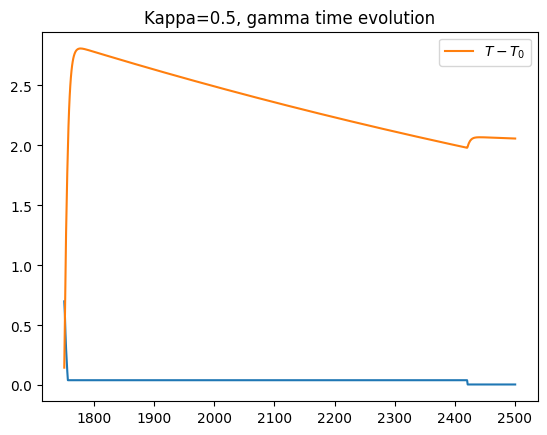

In [10]:
run1 = runs["Constant 4xCO2 forcing, kappa: 0.5"]
#plt.plot(run1.time, run1.tg)
plt.plot(run1.time, run1.gammas)
plt.title("Kappa=0.5, gamma time evolution")
plt.plot(run1.time,(run1.tg- run1.tlev[:,1]), label = "$T-T_0$")
#plt.ylim(0,0.3)
plt.legend()

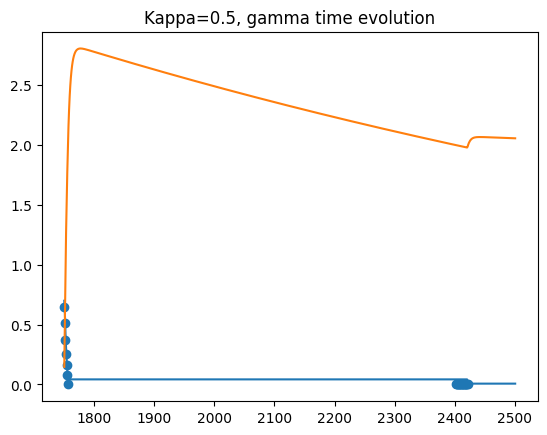

In [12]:
#we expect gamma to be limited at indices:

inds = np.where(0.7*(1-0.5*(run1.tg- run1.tlev[:,1])) > 0)
#print(0.7*(1-0.5*(run1.tg- run1.tlev[:,1]))[inds])

#plt.plot(run1.time, run1.tg)
plt.plot(run1.time, run1.gammas)
plt.title("Kappa=0.5, gamma time evolution")
plt.plot(run1.time,(run1.tg- run1.tlev[:,1]), label = "$T-T_0$")
plt.scatter(run1.time[inds],0.7*(1-0.5*(run1.tg- run1.tlev[:,1]))[inds])